In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis,integral
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist
from jax.scipy.special import gammaln
from astropy.cosmology import WMAP9 as cosmo
from scipy.optimize import curve_fit, brentq
import fitting

2024-09-27 09:23:35.478511: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [3]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [4]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]
Computation result: [1. 4. 9.]


In [5]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [6]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

In [7]:
d_desi = Planck18.distmod(z_desi).value

In [8]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [9]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.31)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

4434


In [10]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [11]:
gamma1, gamma2, L_star, phi_star = get_lfpars("shen20",2.305)
alpha = -(gamma1+1)
beta = -(gamma2+1)
#print(integral(0.1,alpha,beta))
N_obs = fitting.N_obs(2.3,2.31)
#print(integral(0.1,alpha,beta).dtype)
N_obs(20,0.2,0,alpha,beta,0.1,k_rr)
def eff(m):
    eff = jnp.where(m < 20, 1, 10**(-0.1*(m-20)/2.5))
    return eff

lg_lkh = fitting.ln_posterior(eff)
lg_lkh = lg_lkh(20,0.1,0,alpha,beta,apr_mag_r,k_rr,d_desi,apr_mag_r_err)

In [12]:
def model(zmin,zmax,alpha,beta,apr_mag,k,mu,apr_mag_err):
    x = numpyro.sample('x', dist.Uniform(0,3))
    m0 = numpyro.sample('m0', dist.Uniform(17, 20))
    b = numpyro.sample('b', dist.Uniform(0, 1))
    
    def eff(m):
        eff = jnp.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
        return eff
    
    ln_posterior = fitting.ln_posterior(eff)
    
    log_likelihood = ln_posterior(m0, b, x, alpha, beta, apr_mag, k, mu, apr_mag_err)
    
    numpyro.factor("log_likelihood",log_likelihood)

In [13]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 1000, 2000
i_start = 0
i_end = i_start+1000
# Initialize batch parameters for the entire datasetw

init_params = {
    'x': -1.80 * jnp.ones((1,)),  
    'm0': 18.54 * jnp.ones((1,)),
    #'a': 0.0128 * jnp.ones((1,)),
    'b': 7 * jnp.ones((1,)),
    #'c': 175605 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, 2.3,2.31,alpha,beta,apr_mag_r,k_rr,d_desi,apr_mag_r_err)
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 3000/3000 [07:30<00:00,  6.66it/s, 27 steps of size 3.48e-02. acc. prob=0.84] 


{'b': Array([0.05550766, 0.05563119, 0.05538701, ..., 0.05570713, 0.0555353 ,
       0.05570655], dtype=float64), 'm0': Array([17.1337667 , 17.23638444, 17.16283003, ..., 17.14056123,
       17.15192876, 17.09702117], dtype=float64), 'x': Array([0.00015558, 0.00013269, 0.00014601, ..., 0.00021907, 0.00016268,
       0.00016058], dtype=float64)}


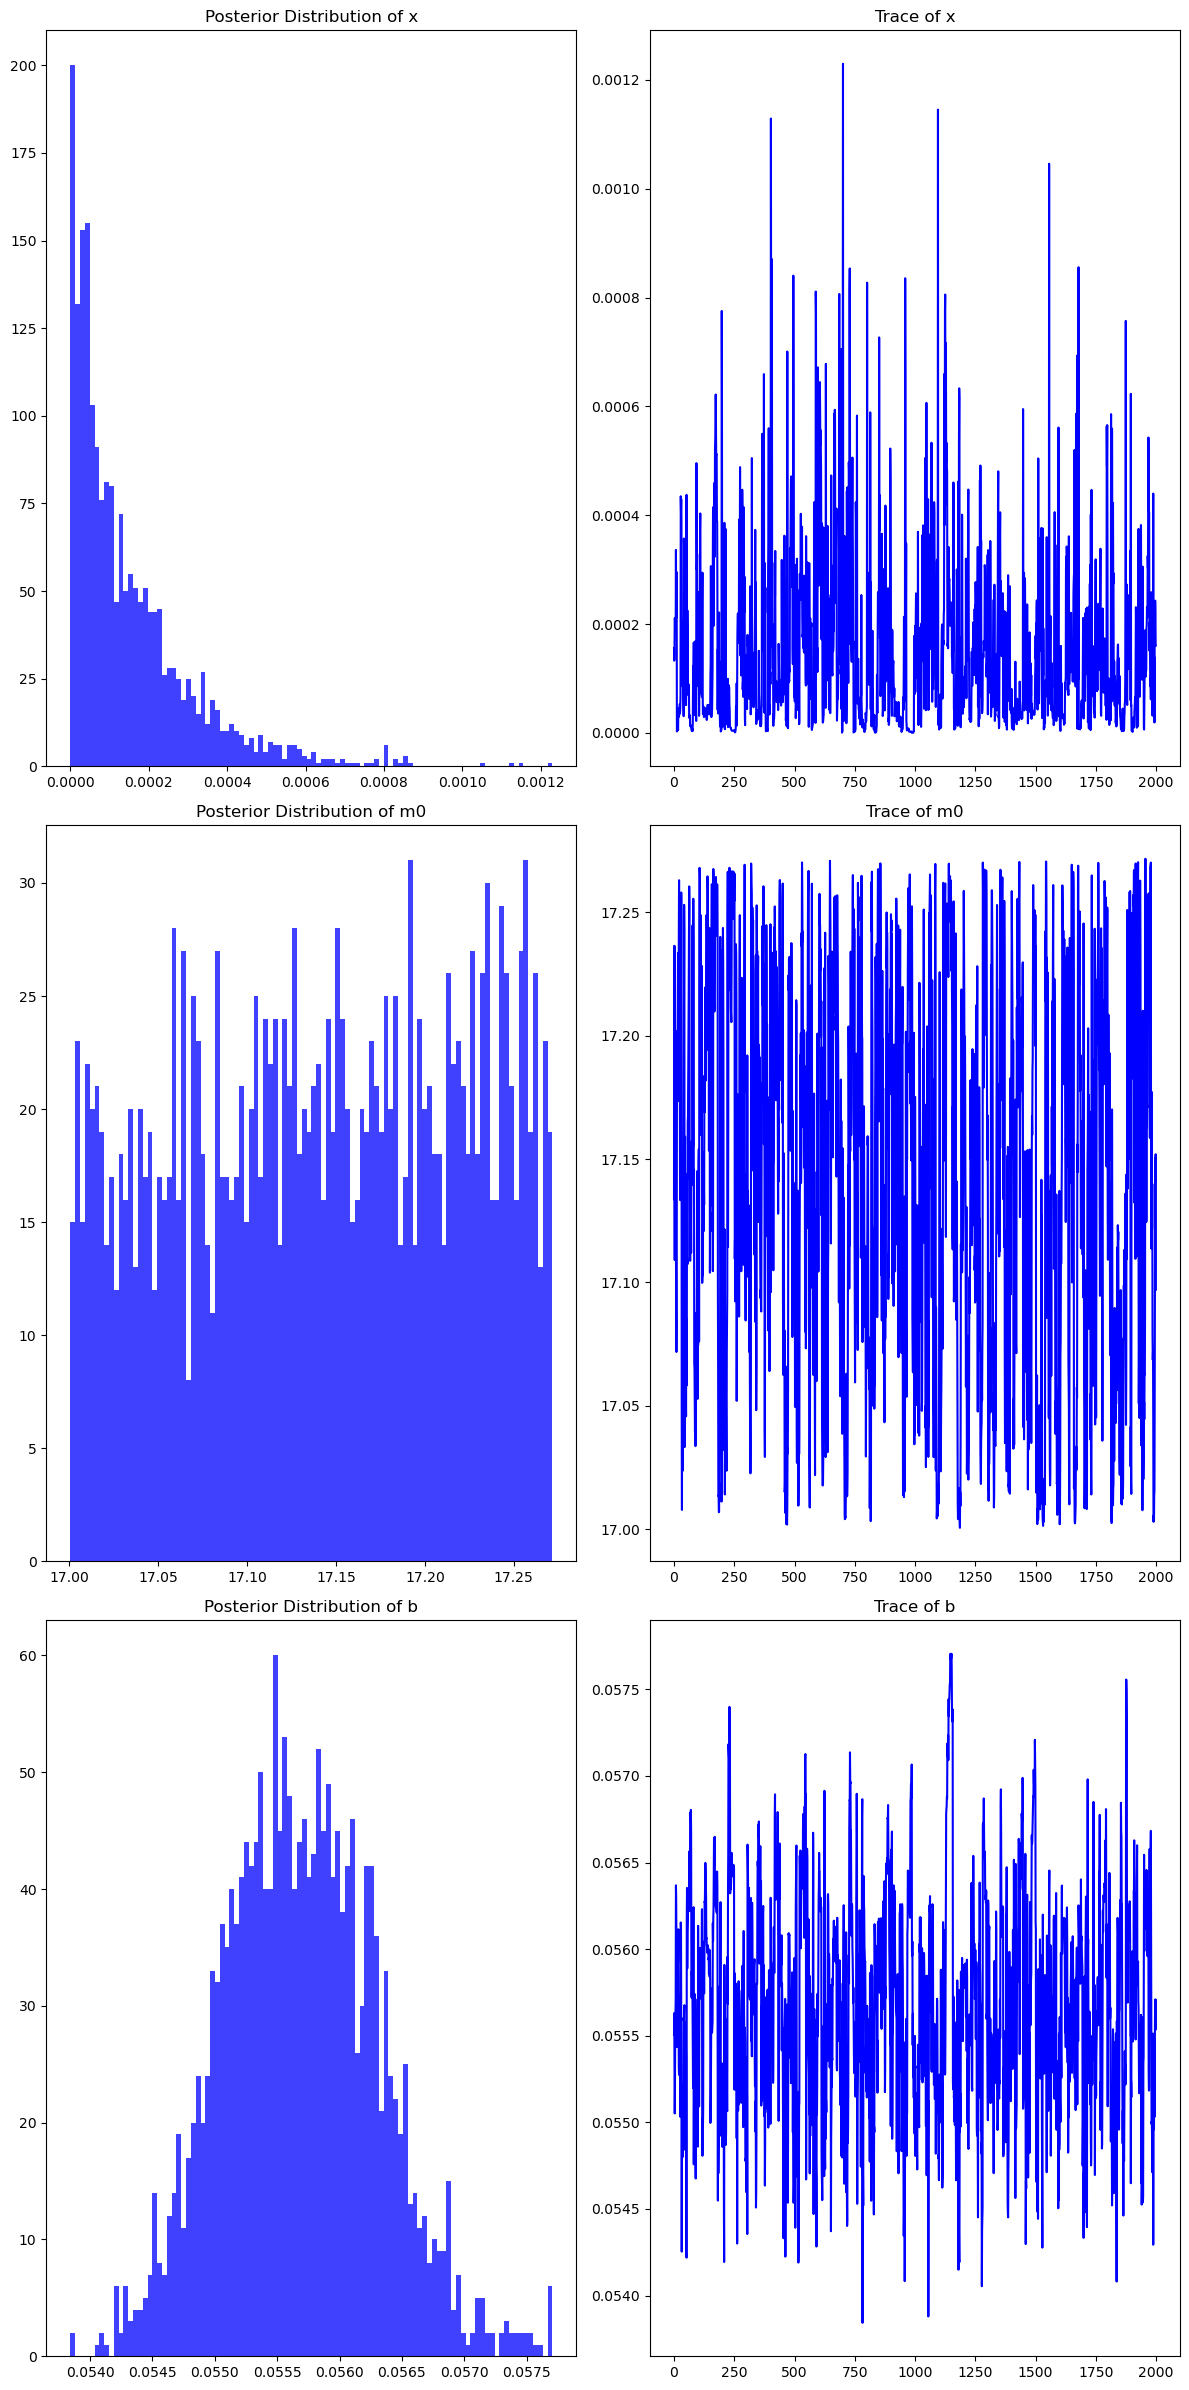

In [14]:
# Extract the chains and parameters
samples = mcmc.get_samples()
x = samples['x']
m0 = samples['m0']
b = samples['b']

# Creating a figure to hold the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 24))  

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
#plot_param(axs[2],a,'a')
plot_param(axs[2],b,'b')
#plot_param(axs[4],c,'c')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

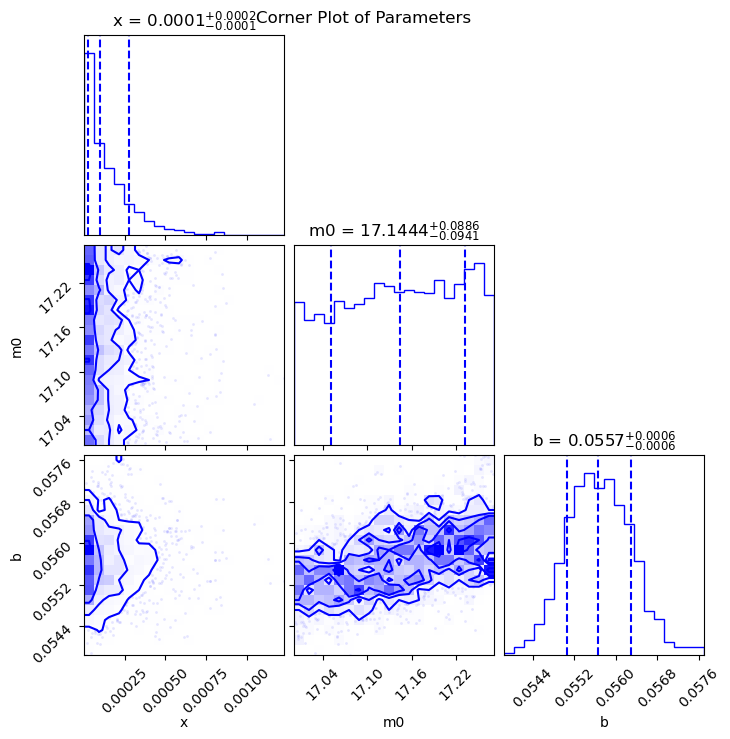

In [15]:
import corner
# Extract samples for plotting
#samples = np.vstack((x, m0)).T
samples = np.vstack((x,m0,b)).T
# Create a corner plot
fig = corner.corner(samples, labels=['x', 'm0','b'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()

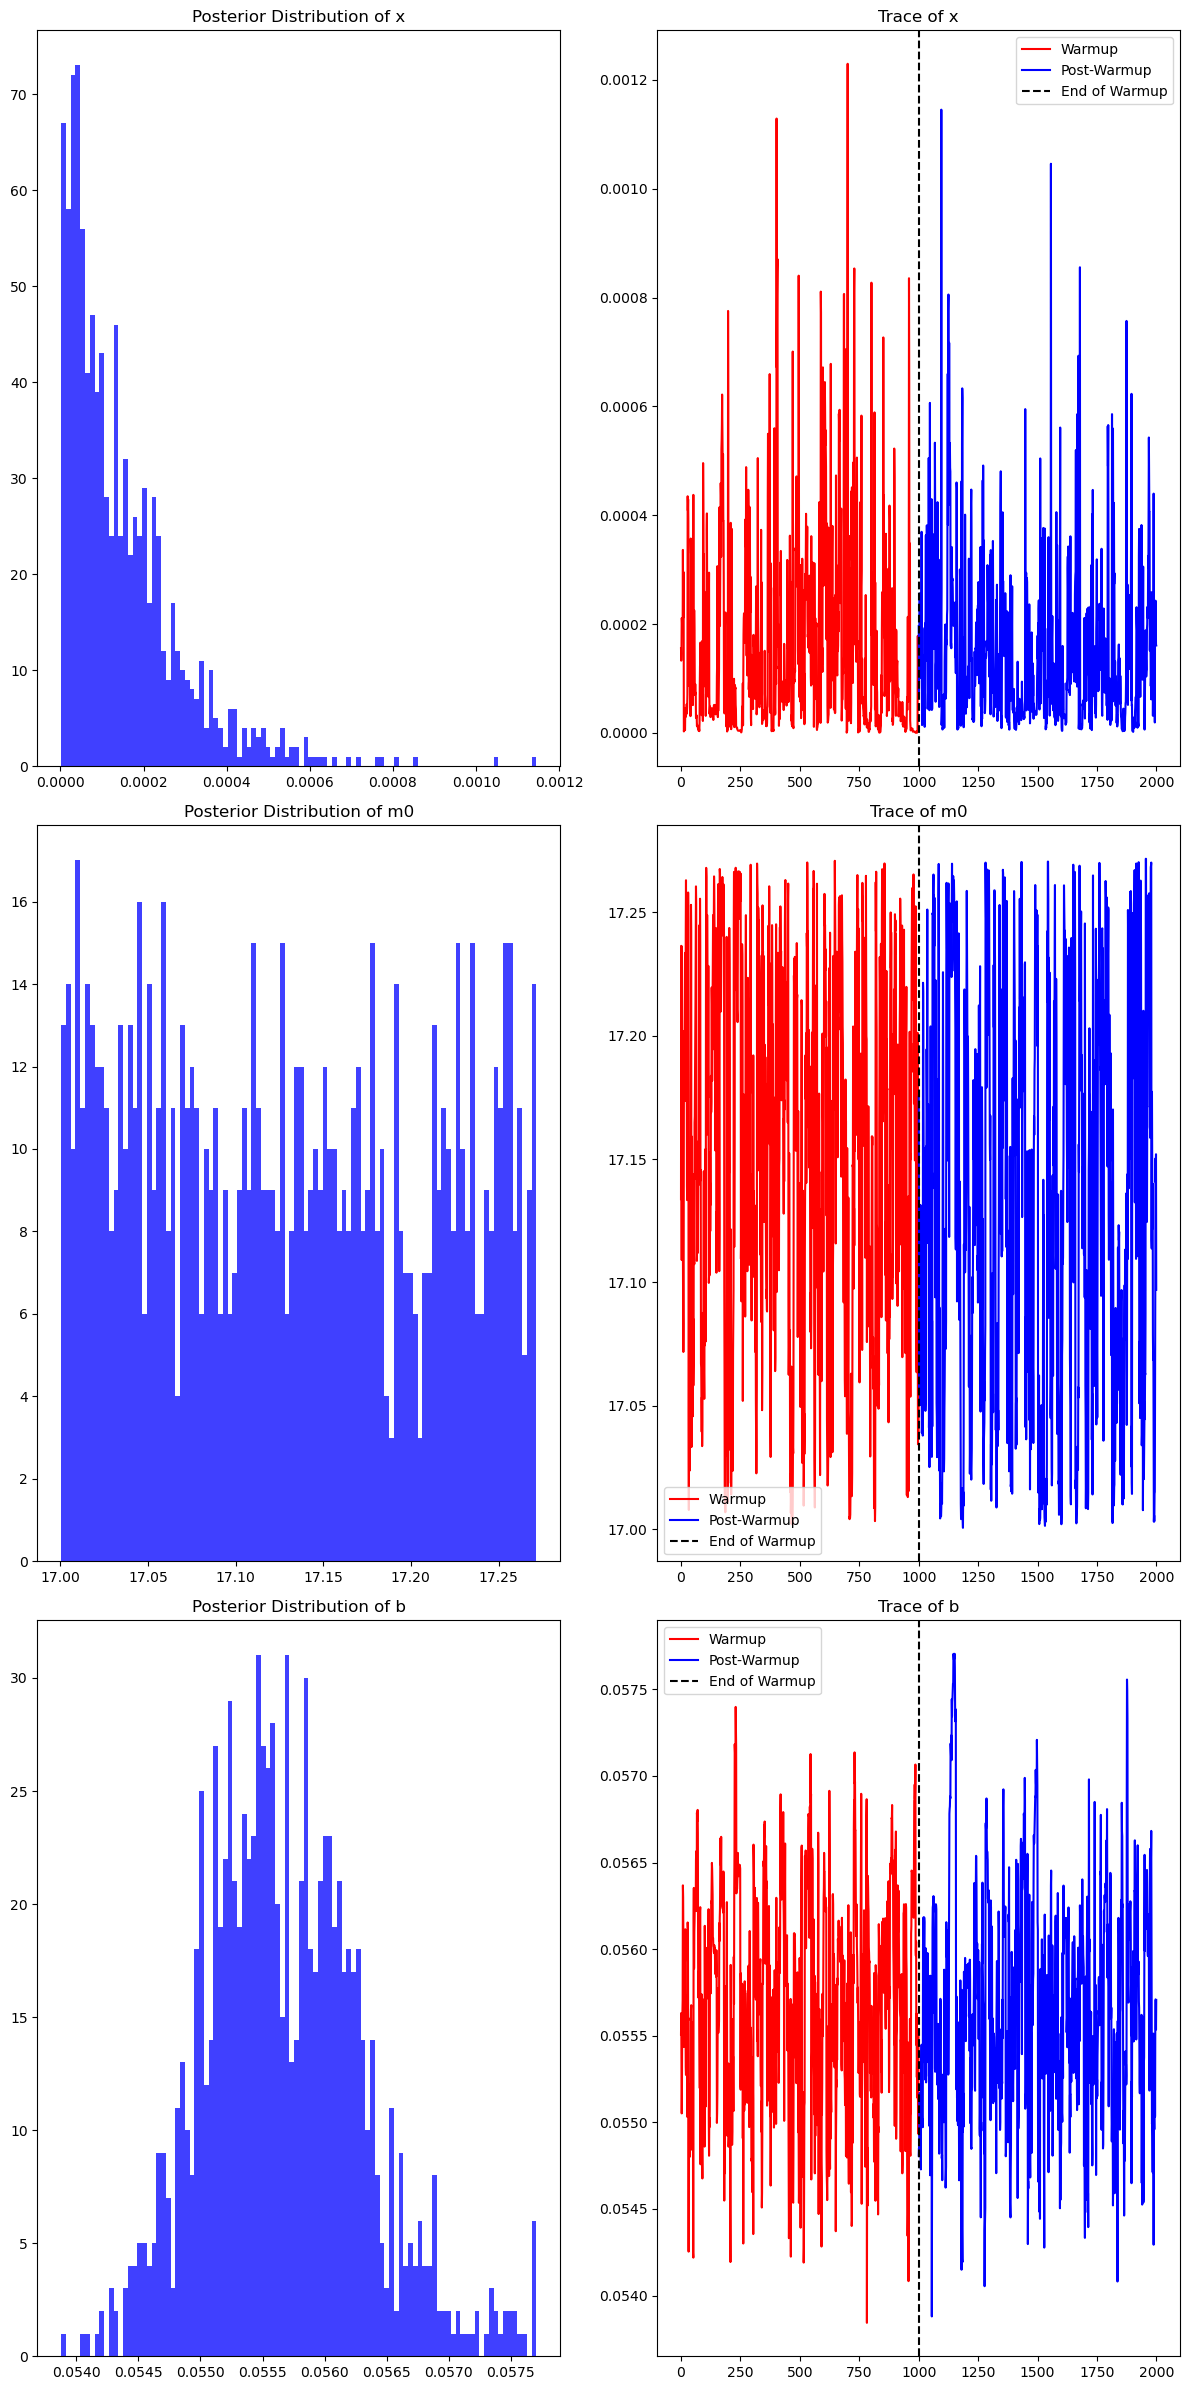

In [16]:
# Extract all chains, including warmup steps
all_samples = mcmc.get_samples(group_by_chain=True)

# Convert JAX arrays to NumPy arrays
all_samples = {k: np.array(v.block_until_ready()) for k, v in all_samples.items()}

# Number of warmup samples
num_warmup = mcmc.num_warmup

# Extract the parameter chains
x = all_samples['x'].flatten()
m0 = all_samples['m0'].flatten()
#a = all_samples['a'].flatten()
b = all_samples['b'].flatten()

# Creating a figure to hold the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 24))

# Helper function to plot histograms and traces with warmup steps
def plot_param(ax, data, title):
    warmup_data = data[:num_warmup]
    post_warmup_data = data[num_warmup:]
    
    # Plot histogram of post-warmup samples
    ax[0].hist(post_warmup_data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    
    # Plot trace with warmup steps in a different color
    ax[1].plot(range(num_warmup), warmup_data, color='red', label='Warmup')
    ax[1].plot(range(num_warmup, len(data)), post_warmup_data, color='blue', label='Post-Warmup')
    ax[1].set_title(f'Trace of {title}')
    ax[1].axvline(x=num_warmup, color='black', linestyle='--', label='End of Warmup')
    ax[1].legend()

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
#plot_param(axs[2], a, 'a')
plot_param(axs[2], b, 'b')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()